In [1]:
import numpy as np
import matplotlib.pyplot as plt
from model_base import get_default_params, NetworkModel
from experiments import get_null_ff_input_arrays
import ipywidgets as widgets
plt.style.use('pretty')
%matplotlib notebook

In [2]:
N_cells, w_mean, conn_prob, bg_inputs, taus = get_default_params(flag_mean_pop=True)
wED = 0.7
model = NetworkModel(N_cells, w_mean, conn_prob, taus, bg_inputs, wED=wED, flag_SOM_ad=False,
                     flag_w_hetero=False, flag_pre_inh=False)



<IPython.core.display.Javascript object>


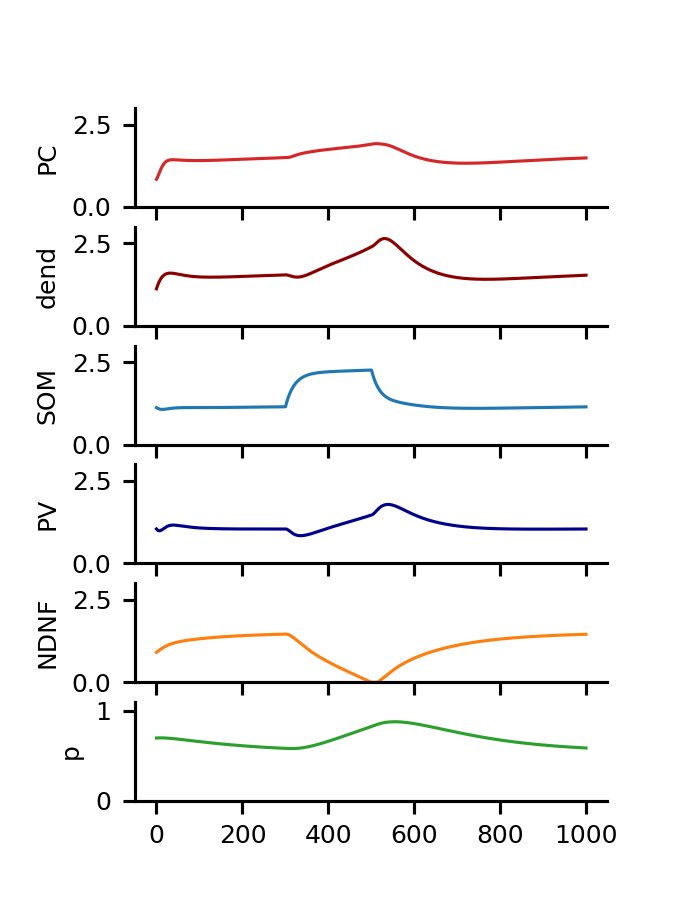

interactive(children=(FloatSlider(value=0.5, description='wPS', max=2.0), FloatSlider(value=1.0, description='…

In [8]:
# simulation parameters
dur = 1000
dt = 1
nt = int(dur/dt)
ts, te = 300, 500
I_activate = 1



fig1, ax1 = plt.subplots(6, 1, figsize=(3, 4), dpi=150, sharex=True, sharey='row', gridspec_kw={'left':0.2})
for i, label in enumerate(['PC', 'dend', 'SOM', 'PV', 'NDNF', 'p']):
    ax1[i].set(ylabel=label, ylim=[0, 3])
ax1[-1].set(ylim=[0,1.1])

@widgets.interact(wPS=(0, 2, 0.1), wEP=(0, 2, 0.1), wED=(0, 2, 0.1), wDS=(0, 2, 0.1), wDN=(0, 2, 0.1), wNS=(0, 2, 0.1),
                  wPN=(0, 2, 0.1), wSE=(0, 2, 0.1), wPE=(0, 2, 0.1),
                  xE=(0, 2, 0.1), xD=(0, 3, 0.1), xP=(0, 2, 0.1), xS=(0, 2, 0.1), xN=(0, 3, 0.1),
                  b=(0, 1, 0.1))
def update(wPS=0.5, wEP=1, wED=1, wDS=0.5, wDN=1.5, wPN=0.5, wNS=1, wSE=0.5, wPE=0.7,
           xE=1.3, xD=2.8, xP=1.5, xS=0.5, xN=2.2,
           b=0):
    
    for ii in range(6):
        [l.remove() for l in ax1[ii].lines]
    
    N_cells, w_mean, conn_prob, bg_inputs, taus = get_default_params(flag_mean_pop=True)
    
    p_init = 1-b*1
    
    w_mean['PS'] = wPS
    w_mean['EP'] = wEP
    w_mean['DS'] = wDS/p_init
    w_mean['PN'] = wPN
    w_mean['DN'] = wDN/p_init
    w_mean['NS'] = wNS/p_init
    w_mean['SE'] = wSE
    w_mean['PE'] = wPE
    w_mean['NN'], w_mean['PP'] = 0, 0 # no self-inhibition
    
    
    bg_inputs['E'] = xE
    bg_inputs['D'] = xD
    bg_inputs['S'] = xS
    bg_inputs['P'] = xP
    bg_inputs['N'] = xN
    
    print(wPS - wPN*wNS, wDN*wNS - wDS)
    
    model = NetworkModel(N_cells, w_mean, conn_prob, taus, bg_inputs, wED=wED, flag_SOM_ad=False,
                         flag_w_hetero=False, flag_pre_inh=True, flag_with_VIP=False)
    model.b=b

    xFF = get_null_ff_input_arrays(nt, N_cells)
    xFF['S'][ts:te, :] = I_activate  # N_cells[cell]//2
    
    t, rE, rD, rS, rN, rP, rV, p, other = model.run(dur, xFF, dt=dt, p_init=p_init)

    
    ax1[0].plot(t, rE, c='C3', alpha=1)
    ax1[1].plot(t, rD, c='darkred', alpha=1)
    ax1[2].plot(t, rS, c='C0', alpha=1)
    #     ax1[4].plot(t, rN, c='C1', alpha=0.5)
    ax1[3].plot(t, rP, c='darkblue', alpha=1)
    ax1[4].plot(t, rN, c='C1', alpha=1)
    ax1[5].plot(t, p, c='C2', alpha=1)
plt.show()
